In [1]:
!pip install -q keras

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256      #Initializing the image size
BATCH_SIZE = 32       #Initializing the batchsize
CHANNELS = 3          #Initializing the rgb channels
EPOCHS = 50           #Inintializing the number of epochs

In [4]:
  data = tf.keras.preprocessing.image_dataset_from_directory(
      "../Plant",
      shuffle=True,
      image_size= (IMAGE_SIZE,IMAGE_SIZE),
      batch_size= BATCH_SIZE
  )

Found 2152 files belonging to 3 classes.


Lest Check out the class name we the dataset

 - Potato-Early-blight 
 - Potato-late-blight
 - Potato-healthy

In [5]:
class_namz = data.class_names
class_namz

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:

print("The dataset is divided into 32 image batchsizes by default so that means if the 2152/32 making: ", len(data) ,"batches")

The dataset is divided into 32 image batchsizes by default so that means if the 2152/32 making:  68 batches


In [7]:
print("Here we are printing the image batch sizes for \n for the 1st 32 images and there label category 0,1,2 \n as well as their shapes")

for image_batch, label_batch in data.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

Here we are printing the image batch sizes for 
 for the 1st 32 images and there label category 0,1,2 
 as well as their shapes
(32, 256, 256, 3)
[1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0]


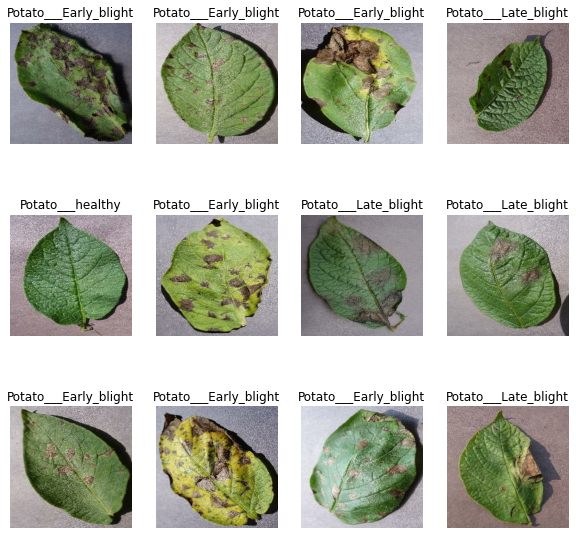

In [8]:

plt.figure(figsize=(10, 10))                             ## setting the image size to 10 by 10

for image_batch, label_batch in data.take(1):            ## iterating through batch_size and image labels
  for i in range(12):                                    ## for a range of 12 images out of the 32 batchsize
    ax = plt.subplot(3,4,i+1)                            ## Create a sublot of 3 by 4 dimension and increase by 1 image
    plt.imshow(image_batch[i].numpy().astype("uint8"))   ## show one image atin the numpy format of the batch size
    plt.title(class_namz[label_batch[i]])                ## Showing the image labels on top of each image
    plt.axis("off")                                      ## Removing the axis 
  

In [9]:
# 80% ==> training,            # splittign 80% or 0.8 for training data
# 10% ==> validation,          # splitting 10% or 0.1 for validation data
# 10% ==>  test                # splitting 10% or 0.1 for the test data


In [10]:
train_size = 0.8              # Establishin the 80% training set which estimates to take 54 batch size images
len(data)*train_size

54.400000000000006

In [11]:
train_ds = data.take(54)      # taking the first 54 batch size images as training data ie take similar data[:54]
len(train_ds)

54

In [12]:
 test_ds = data.skip(54)       # taking the next 54 images batch sizes using skip() similar to data[54:] as test data
 len(test_ds)

14

In [13]:
val_size=0.1                  # Establishsing the 10% for the validation data from the data which is 6
len(data)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)      # created the 10% validation data from the test set and we taken 6 image batch sizes
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(val_ds)

6

In [16]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size=int(train_split * ds_size)
  val_size = int(val_split* ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  
  return train_ds,  val_ds, test_ds
   

In [17]:
train_ds,  val_ds, test_ds = get_dataset_partitions(data)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

- Fetching the train data Model from the hard-disk in cache memory

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

- Resizing the Images shapes for prediction

In [22]:
resize_and_rescale = tf.keras.Sequential([
          layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
          layers.experimental.preprocessing.Rescaling(1.0/255)
])

- Data augmenataion to rotate the shapes of the images for the model to learn all aspects of the image.

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

- Building the convolutional layers for the model to work 

NB:
- Areas to twick can include the number of opening layers 32 to any other figure

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),  # 32-layers, (3,3)-filter size, activation function
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')               # softmax helps to normalize the probabilities in the dense layer
])

model.build(input_shape=input_shape)

In [25]:
model.summary()           # viewing the trainable parameters

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [26]:
# Using the adam optimizer to track the gradient descent in the training process
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 168s 3s/step - loss: 0.9086 - accuracy: 0.4948 - val_loss: 0.8812 - val_accuracy: 0.6562
Epoch 2/50
54/54 [==============================] - 143s 3s/step - loss: 0.6552 - accuracy: 0.7060 - val_loss: 0.4240 - val_accuracy: 0.8021
Epoch 3/50
54/54 [==============================] - 155s 3s/step - loss: 0.3991 - accuracy: 0.8374 - val_loss: 0.3365 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 143s 3s/step - loss: 0.3366 - accuracy: 0.8605 - val_loss: 0.4278 - val_accuracy: 0.7917
Epoch 5/50
54/54 [==============================] - 149s 3s/step - loss: 0.2228 - accuracy: 0.9045 - val_loss: 0.3128 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 139s 3s/step - loss: 0.1528 - accuracy: 0.9398 - val_loss: 0.4635 - val_accuracy: 0.8177
Epoch 7/50
54/54 [==============================] - 169s 3s/step - loss: 0.2047 - accuracy: 0.9225 - val_loss: 0.3158 - val_accuracy: 0.8646
Epoch 8/50
54

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 10s 914ms/step - loss: 0.2149 - accuracy: 0.9258


In [29]:
scores

[0.21492436528205872, 0.92578125]

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
history.history['accuracy']

[0.4965277910232544,
 0.6973379850387573,
 0.7702546119689941,
 0.8628472089767456,
 0.8912037014961243,
 0.9074074029922485,
 0.9039351940155029,
 0.9357638955116272,
 0.9293981194496155,
 0.9421296119689941,
 0.9351851940155029,
 0.9525462985038757,
 0.9380787014961243,
 0.9450231194496155,
 0.9565972089767456,
 0.953125,
 0.9641203880310059,
 0.9635416865348816,
 0.9600694179534912,
 0.9629629850387573,
 0.9803240895271301,
 0.9797453880310059,
 0.9675925970077515,
 0.9803240895271301,
 0.9635416865348816,
 0.9681712985038757,
 0.9861111044883728,
 0.9907407164573669,
 0.9826388955116272,
 0.9739583134651184,
 0.9826388955116272,
 0.9809027910232544,
 0.9861111044883728,
 0.9826388955116272,
 0.9866898059844971,
 0.9716435074806213,
 0.9837962985038757,
 0.9855324029922485,
 0.9878472089767456,
 0.9866898059844971,
 0.9895833134651184,
 0.9872685074806213,
 0.9924768805503845,
 0.9849537014961243,
 0.9924768805503845,
 0.9861111044883728,
 0.9832175970077515,
 0.9895833134651184,
 0

- Lets plot the training an validation accuracy

In [32]:
acc =  history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

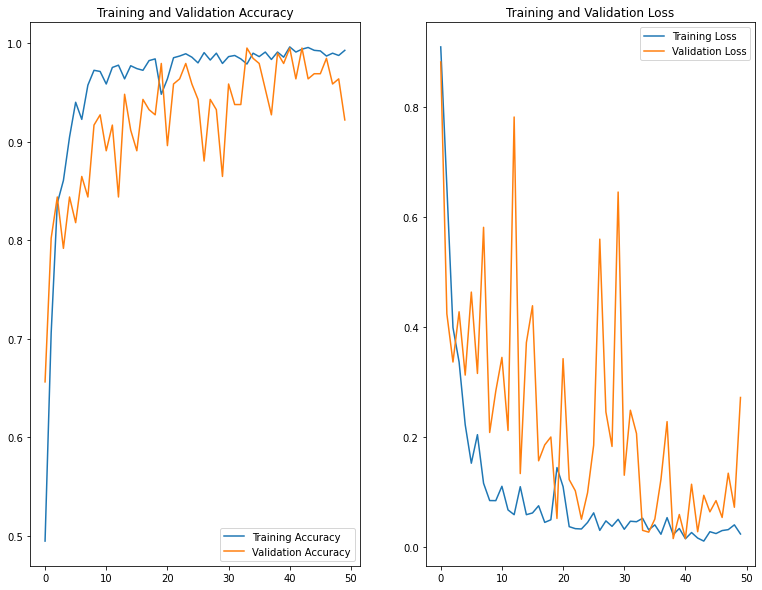

In [33]:
plt.figure(figsize=(13, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
import numpy as np

# np.argmax([])   Need find out what np.argmax() does

first image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
Predicted label: Potato___Early_blight


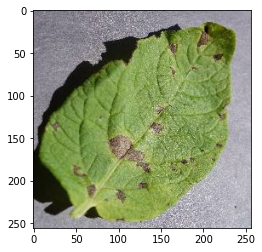

In [35]:
for images_batch, labels_batch in test_ds.take(1):    #take(1) represents the first image_batch

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('Actual label:',class_namz[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted label:", class_namz[np.argmax(batch_prediction[0])])     
  
                             

In [36]:
def predict(model, img):         # function to help show the confidence levels on the predicted images
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_namz[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 61ms/step


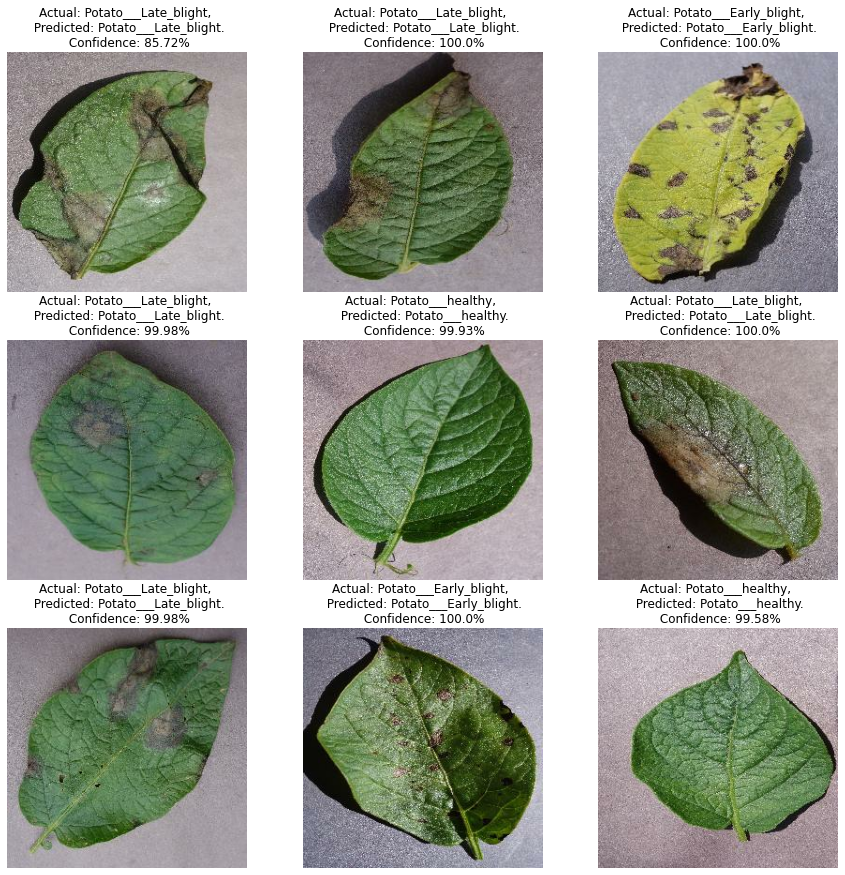

In [37]:
plt.figure(figsize=(15, 15))             # loop to help print the predicted image vs its confidence levels
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_namz[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")


- Saving my model to the googel drive folder

In [37]:
# model_version = 1
# model.save(f"/content/drive/MyDrive/Coffee Quality Model/Saved Models{model_version}")

In [1]:
# Saving the  model to folder 3
# MODEL_PATH =  '../saved-models/3'  

# model.save(MODEL_PATH)

In [40]:
## save model to folder 2 into a h5 file

# save_path = '../Saved_Model/2/model.h5'
# model.save(save_path)

In [65]:
# saving my model to google drive folder

# MODEL_PATH =  '/content/drive/MyDrive/Coffee Quality Model/Saved Models'  

# model.save(MODEL_PATH)